# Latent Processing Analysis

This notebook performs a latent processing analysis on the latent space of the MaxP5_3 beta Variational Autoencoder. This analysis was not part of the main experiment but was used to understand whether the clustering can be improved using a different autoencoder. 

In [ ]:
import base64
from PIL import Image
import io
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap
import hdbscan
from tqdm import tqdm
import os
from facesim3d import local_paths


output_dir = local_paths.DIR_PCA_AE_RESULTS_betaVAE

# Load latent space and image paths
latents = np.load(os.path.join(output_dir, "latent_codes_beta_VAE_HJ.npy"))  # shape: (n_samples, latent_dim)
print(f"Loaded {latents.shape[0]} latent vectors with shape {latents.shape}.")

Loaded 185473 latent vectors with shape (185473, 32).


In [ ]:
paths = np.load(os.path.join(output_dir, "image_paths_beta_VAE_HJ.npy"), allow_pickle=True)  # list of image file paths
print(f"Example image path: {paths[0]}")

# extract filename base for matching it with metadata
def extract_base(p):
    base = os.path.basename(p)
    # Convert .png to .npy since metadata heatmap_file column stores .npy
    if base.endswith(".png"):
        base = base.replace(".png", ".npy")
    return base

path_bases = [extract_base(p) for p in paths]
print(f"Example base image path: {path_bases[0]}")

Example image path: /work/lg77sypy-create_AE_training_data/scripts/single_LRP_HJ_heatmaps/single_heatmaps/triplet148544_gt081.png
Example base image path: triplet148544_gt081.npy


In [ ]:
metadata_folder = local_paths.DIR_SINGLE_HJ_HEATMAPS
meta = pd.read_csv(os.path.join(metadata_folder, "single_heatmaps_metadata.csv"))     # must match order of latents
meta.head()

,dataset_idx,head1,head2,head3,gt_odd_head,model_pred,human_choice_index,correct,heatmap_file
0,112139,13,98,14,98,1,1,1,triplet112139_gt098.npy
1,8677,44,61,69,44,0,0,1,triplet08677_gt044.npy
2,89702,22,34,39,22,0,0,1,triplet89702_gt022.npy
3,79468,44,81,29,29,2,2,1,triplet79468_gt029.npy
4,25396,20,19,85,19,1,1,1,triplet25396_gt019.npy


In [19]:
# add head id column:
head_cols = ["head1", "head2", "head3"]

# Convert the 3 head columns to a numpy array of shape (N, 3)
heads = meta[head_cols].to_numpy()        # shape: (N, 3)

# model_pred contains integers 0,1,2 → use as column index
pred = meta["model_pred"].to_numpy()      # shape: (N,)

# Gather the correct head per row
meta["head_index"] = heads[np.arange(len(meta)), pred]
meta.head()

,dataset_idx,head1,head2,head3,gt_odd_head,model_pred,human_choice_index,correct,heatmap_file,head_index
0,112139,13,98,14,98,1,1,1,triplet112139_gt098.npy,98
1,8677,44,61,69,44,0,0,1,triplet08677_gt044.npy,44
2,89702,22,34,39,22,0,0,1,triplet89702_gt022.npy,22
3,79468,44,81,29,29,2,2,1,triplet79468_gt029.npy,29
4,25396,20,19,85,19,1,1,1,triplet25396_gt019.npy,19


In [48]:
# align meta with the order of latents
meta = meta.set_index("heatmap_file").loc[path_bases].reset_index()

In [5]:
# Normalize latent vectors
scaler = StandardScaler()
latents_scaled = scaler.fit_transform(latents)

In [6]:
reducer = umap.UMAP(n_components=2, random_state=42)
umap_2d = reducer.fit_transform(latents_scaled)

/home/sc.uni-leipzig.de/lg77sypy/.conda/envs/clustering_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/sc.uni-leipzig.de/lg77sypy/.conda/envs/clustering_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
np.save(os.path.join(DIR_PCA_AE_RESULTS_betaVAE, "latent_UMAP_beta_VAE_HJ.npy"), umap_2d)

In [ ]:
import numpy as np 

# Load again once calculated
latents_2d = np.load(os.path.join(DIR_PCA_AE_RESULTS_betaVAE, "latent_UMAP_beta_VAE_HJ.npy"))
print('Loaded UMAP representations')

Loaded UMAP representations


In [24]:
# map each head ID to the corresponding path using the meta data
# Extract head IDs from meta dataframe
head_ids = []
for idx, row in meta.iterrows():
    # Get the predicted head ID using model_pred index
    pred_index = int(row['model_pred'])
    
    # Extract head columns (head1, head2, head3)
    head_columns = ['head1', 'head2', 'head3']
    head_id = row[head_columns[pred_index]]
    head_ids.append(head_id)

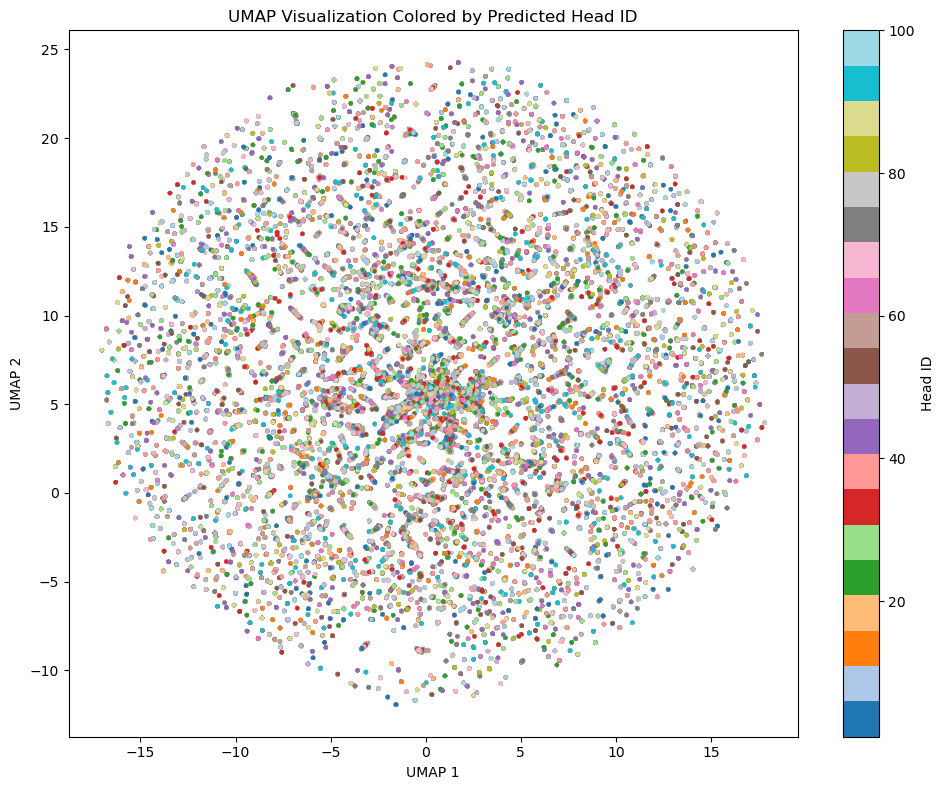

In [ ]:
import matplotlib.pyplot as plt

# Plot using matplotlib
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=head_ids, cmap='tab20',s=10, alpha=1, edgecolors='none')
plt.colorbar(scatter, label='Head ID')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Visualization Colored by Predicted Head ID')
plt.tight_layout()
#plt.savefig(os.path.join(output_dir, "UMAP_latents_beta_VAE"))
plt.show()

In [18]:
from sklearn.manifold import TSNE
# === t-SNE ===
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto')
z_tsne = tsne.fit_transform(latents_scaled)

Running t-SNE...


In [19]:
from sklearn.decomposition import PCA

# === PCA ===
print("Running PCA...")
pca = PCA(n_components=2)
z_pca = pca.fit_transform(latents_scaled)

Running PCA...


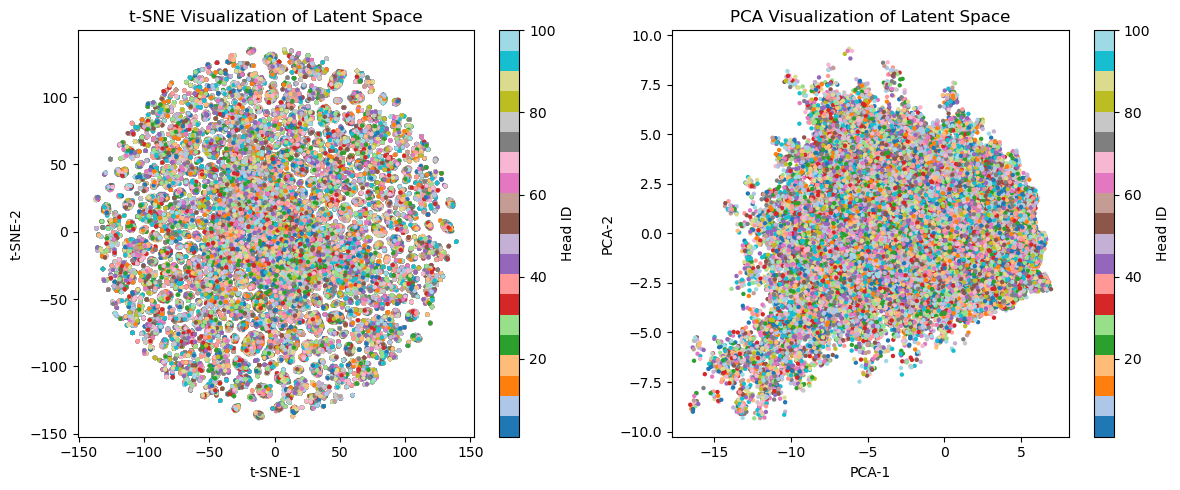

In [ ]:
# === Plot ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=head_ids, cmap='tab20',s=10, alpha=1, edgecolors='none')
plt.colorbar(scatter, label='Head ID')
plt.title("t-SNE Visualization of Latent Space")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")

plt.subplot(1, 2, 2)
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=head_ids, cmap='tab20',s=10, alpha=1, edgecolors='none')
plt.colorbar(scatter, label='Head ID')
plt.title("PCA Visualization of Latent Space")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "TSNE_PCA_Plots_beta_VAE.png"))
plt.show()

## Clustering (on original, normalized data - then visualize in 2D)

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Perform K-means clustering on the original high-dimensional data
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters = kmeans.fit_predict(latents_scaled)

# Calculate silhouette score using a sample for efficiency
sample_size = 20000  # Adjust based on your memory
if len(latents_scaled) > sample_size:
    # Randomly sample indices
    sample_indices = np.random.choice(len(latents_scaled), sample_size, replace=False)
    sample_data = latents_scaled[sample_indices]
    sample_clusters = clusters[sample_indices]
    silhouette_avg = silhouette_score(sample_data, sample_clusters)
    print(f"Sample silhouette score (n={sample_size}): {silhouette_avg:.3f}")
else:
    silhouette_avg = silhouette_score(latents_scaled, clusters)
    print(f"Full silhouette score: {silhouette_avg:.3f}")

Sample silhouette score (n=20000): 0.142


Shilouette Score of <0.5 indicates weak clustering

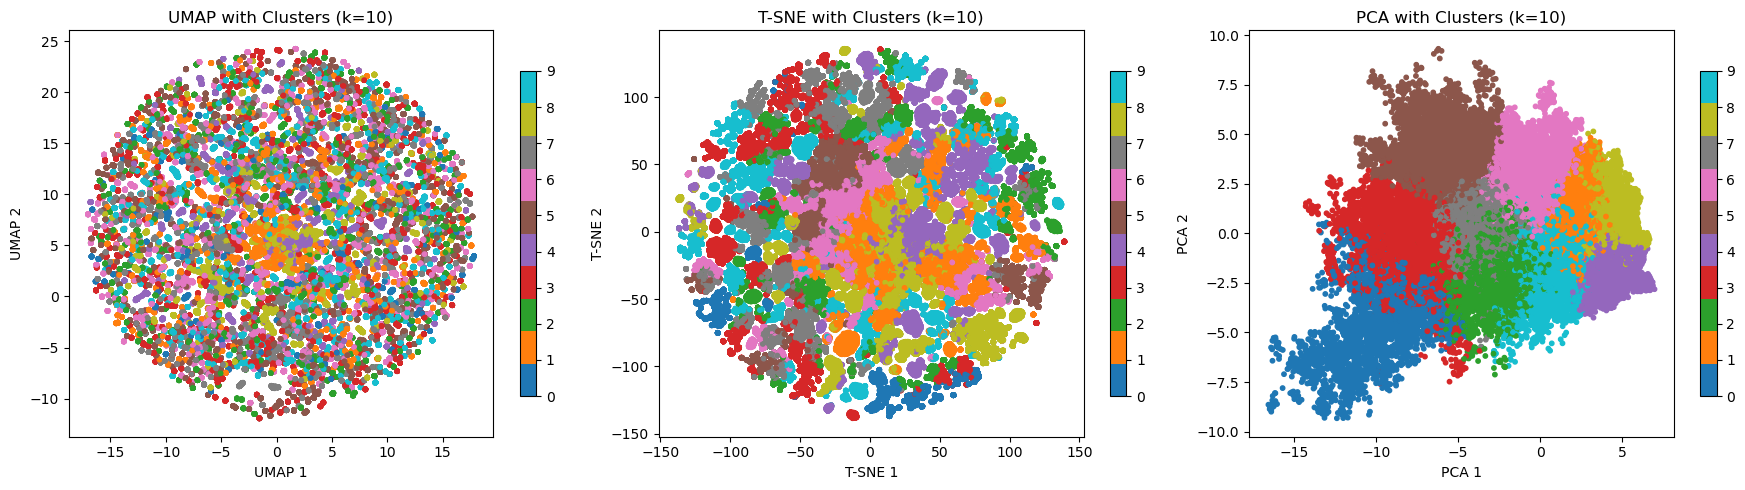

In [ ]:
# Create side-by-side visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# UMAP Clusters
scatter1 = axes[0].scatter(latents_2d[:, 0], latents_2d[:, 1], c=clusters, cmap='tab10', alpha=1, s=10)
axes[0].set_title(f'UMAP with Clusters (k=10)')
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')

# T-SNE Clusters
scatter2 = axes[1].scatter(z_tsne[:, 0], z_tsne[:, 1], c=clusters, cmap='tab10', alpha=1, s=10)
axes[1].set_title(f'T-SNE with Clusters (k=10)')
axes[1].set_xlabel('T-SNE 1')
axes[1].set_ylabel('T-SNE 2')

# PCA Clusters
scatter3 = axes[2].scatter(z_pca[:, 0], z_pca[:, 1], c=clusters, cmap='tab10', alpha=1, s=10)
axes[2].set_title(f'PCA with Clusters (k=10)')
axes[2].set_xlabel('PCA 1')
axes[2].set_ylabel('PCA 2')

# Add colorbar
plt.colorbar(scatter1, ax=axes[0], shrink=0.8)
plt.colorbar(scatter2, ax=axes[1], shrink=0.8)
plt.colorbar(scatter3, ax=axes[2], shrink=0.8)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Clustering_overview_beta_VAE.png"))
plt.show()

In [19]:
# Build a lookup from filename → metadata row
meta_indexed = meta.set_index("heatmap_file")
meta_aligned = meta_indexed.loc[path_bases].reset_index()
print(meta_aligned.head())

              heatmap_file  dataset_idx  head1  head2  head3  gt_odd_head  \
0  triplet148544_gt081.npy       148544     63     81     94           81   
1  triplet100429_gt021.npy       100429     21     29     95           21   
2   triplet90933_gt047.npy        90933      1     47     85           47   
3   triplet66086_gt090.npy        66086     70     90      1           90   
4  triplet173223_gt084.npy       173223      3     84     44           84   

   model_pred  human_choice_index  correct  
0           1                   1        1  
1           2                   0        0  
2           2                   1        0  
3           2                   1        0  
4           1                   1        1  


In [24]:
# HDBSCAN clustering in latent space
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100,   # tune depending on data density
    min_samples=20,
    metric="euclidean",
    cluster_selection_epsilon=0.0,
    cluster_selection_method='eom'
)
cluster_labels = clusterer.fit_predict(latents_scaled)

meta["cluster"] = cluster_labels
print(f"Found {len(np.unique(cluster_labels[cluster_labels >= 0]))} clusters; "
      f"{np.sum(cluster_labels == -1)} points labeled as noise.")

/home/sc.uni-leipzig.de/lg77sypy/.conda/envs/clustering_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/sc.uni-leipzig.de/lg77sypy/.conda/envs/clustering_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Found 242 clusters; 55767 points labeled as noise.


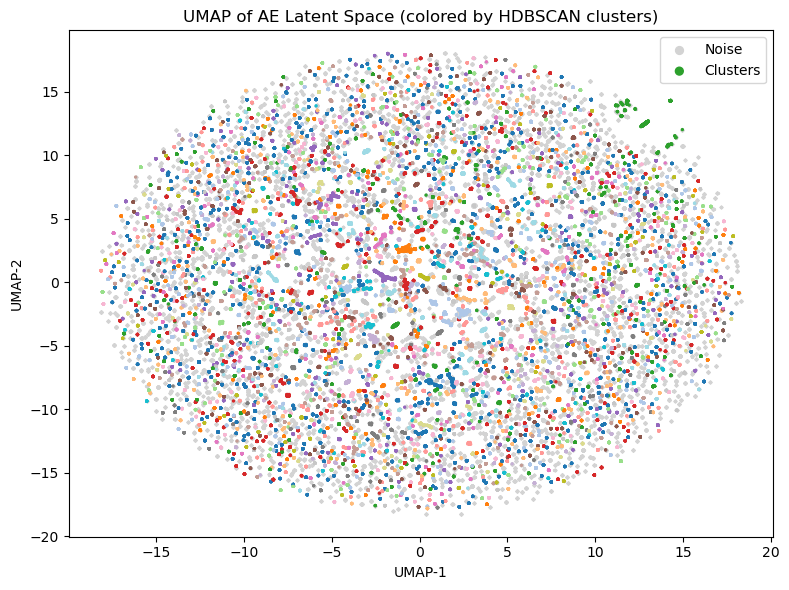

In [26]:
# 5. Visualize clustering result
mask = cluster_labels != -1  # True for clustered points, False for noise

plt.figure(figsize=(8, 6))
plt.scatter(latents_2d[~mask, 0], latents_2d[~mask, 1],
            c="lightgray", s=2, label="Noise")
plt.scatter(latents_2d[mask, 0], latents_2d[mask, 1],
            c=cluster_labels[mask], s=2, cmap="tab20", label="Clusters")
plt.legend(markerscale=4)
plt.title("UMAP of AE Latent Space (colored by HDBSCAN clusters)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()